# Amadeus Data Science Hiring Test Report

This notebook will be my report for the hiring test of Amadeus. For further infrmation, do not hesitate to contact me at [louis.auneau@amadeus.com](mailto:louis.auneau@amadeus.com).

## Abstract

Todo

## Content

[1. Introduction](#1.-Introduction)  
[2. Methods & results](#2.-Methods-&-results)  
...... [2.1 Data collection](#2.1-Data-collection)  
...... [2.2 Data cleaning and pre-processing](#2.2-Data-cleaning-and-pre-processing)  
...... [2.3 Descriptive Analysis](#2.3-Descriptive-Analysis)  
............ [2.3.1 General tendencies](#2.3.1-General-tendencies)  
............ [2.3.2 Products offered](#2.3.2-Products-offered)  
............ [2.3.3 Best selling product overall](#2.3.3-Best-selling-product-overall)  
...... [2.4 Predictive Models](#2.4-Predictive-Models)  
............ [2.4.1 ARIMA](#2.4.1-ARIMA)  
.................. [2.4.1.1 Stationarity analysis and differencing hyper-parameter (d) estimation](#2.4.1.1-Stationarity-analysis-and-differencing-hyper-parameter-(d)-estimation)  
.................. [2.4.1.2 Auto-regression hyper-parameter (p)](#2.4.1.2-Auto-regression-hyper-parameter-(p))  
.................. [2.4.1.3 Moving Average hyper-parameter (q)](#2.4.1.3-Moving-Average-hyper-parameter-(q))  
.................. [2.4.1.4 Model fitting and evaluation](#2.4.1.4-Model-fitting-and-evaluation)  
............ [2.4.2 Random Forests](#2.4.2-Random-Forests)  
[3. Discussion and feedback](#3.-Discussion-and-feedback)  
[4. Resources](#4.-Resources)  

## 1. Introduction

Todo

## 2. Methods & results

### 2.1 Data collection

Let's start by loading all CSVs and display first rows to get a better grasp of the data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics as smg
import numpy as np
import pylab as pl
import sklearn
import math
from datetime import datetime, timedelta
from IPython.display import display

In [3]:
demographic = pd.read_csv("data/demographic.csv")
products = pd.read_csv("data/product.csv")
transactions = pd.read_csv("data/transaction_data.csv")

In [4]:
display(demographic.head())
display(products.head())
display(transactions.head())

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


### 2.2 Data cleaning and pre-processing

#### 2.2.1 Null values

First, we need to check empty values for `DAY`, `WEEK_NO`, `TRANS_TIME`, `SALES_VALUE` and `QUANTITY` columns of the `transactions` dataset, as it will be the columns we are going to manipulate for this project.

In [5]:
transactions.isnull().sum()

household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dtype: int64

There are no null values, so we don't need to replace any value.  
  
#### 2.2.2 Datetime generation
Then, ss our ARIMA model will be a timeserie forcasting model, transforming the transactions' week, day and time into a proper datetime object is necessary. We lack precise dates, so we will choose a baseline date (*1/1/1900*, python's baseline date) and assume transactions started on that day. Regarding transactions' time, it was represented as an integer, with thousands and hundreds used to encode hours, and tens and units used to encode minutes. We are going to parse it and include it in the datetime. This function may take a few minutes to be executed as the task is repeated for all transactions.

In [6]:
def parse_datetime(transaction):
    """
    Takes a transaction row from the `transaction_data.csv` file, and uses `TRANS_TIME` and `DAY` columns to create a datetime object.
    """
    time = transaction["TRANS_TIME"]
    
    if len(time) == 1:
        time = '000'+ time
    elif len(time) == 2: #len being O(1) in python it's ok tu use it twice
        time = '00' + time
        
    return datetime.strptime(time, '%H%M') + timedelta(days=transaction["DAY"] - 1) # (-1 as the `DAY` column is 1 indexed)

In [7]:
transactions["TRANS_TIME"] = transactions["TRANS_TIME"].astype(str) # We need to cast transaction times to avoid automatic coercion by python.
transactions["DATETIME"] = transactions.apply(parse_datetime, axis=1)
display(transactions.head())

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,DATETIME
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1900-01-01 16:31:00
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,1900-01-01 16:31:00
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1900-01-01 16:31:00
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1900-01-01 16:31:00


#### 2.2.3 Sales value timeserie creatiom

The datetime we generated allows us to create a timeserie (as a *Pandas Serie*). We will generate a timeseries at a week scale, which allows us to keep a really good precision for our ARIMA model ($\approx100$ per Box and Tiao [1]), while reducing greatly the size of the data handled by our future models.

In [47]:
weekly_sales_ts = transactions.set_index('DATETIME').groupby(pd.Grouper(freq='W-MON'))['SALES_VALUE'].sum()
daily_sales_ts = transactions.set_index('DATETIME').groupby(pd.Grouper(freq='D'))['SALES_VALUE'].sum()
display(weekly_sales_ts.head())

print("Reduction factor: " + str(transactions.shape[0]/weekly_sales_ts.count()))
print("Number of observations: " + str(weekly_sales_ts.count()))

DATETIME
1900-01-01      549.31
1900-01-08     8145.14
1900-01-15    12408.80
1900-01-22    14215.70
1900-01-29    17122.18
Freq: W-MON, Name: SALES_VALUE, dtype: float64

Reduction factor: 25044.744897959183
Number of observations: 98


We can see that we divided our timeserie size by **3625** using a day scale.

### 2.3 Descriptive Analysis

#### 2.3.1 General tendencies

Let's start by plotting our sales timeserie.

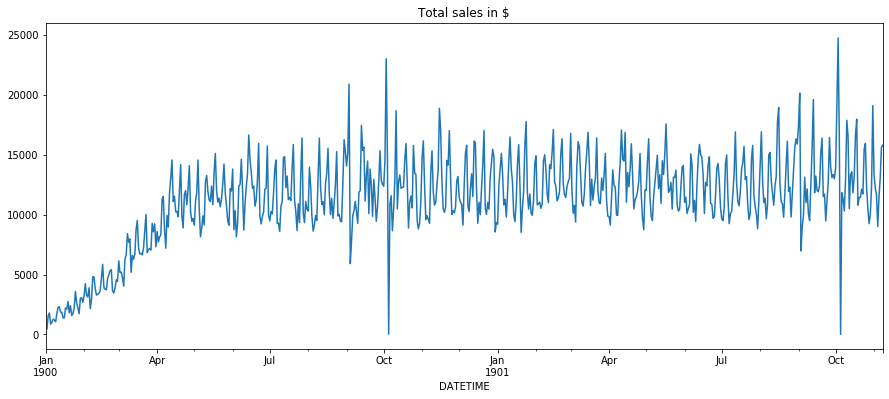

In [34]:
daily_sales_ts.plot(title="Total sales in $", figsize=(15, 6))

We already see some trends : 
- Sales aren't stationnary over the first few month. This can have an influence on our models (particularly the ARIMA Model). This might be due to a business size growth, not correlated to intrinsict sales growth,
- on the other hand, sales are quite stationary afterwards,
- sales reach a peak on the 10th month, and a year after, which may indicate some seasonality.

We can also get basic descriptive statistics about transactions and weekly sales values in order to better grasp our dataset. Products and demographic datasets having mainly qualitative columns, there are not really interesting.

In [10]:
transactions.describe()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
count,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06,2.454385e+06
mean,1.271389e+03,3.356323e+10,3.711756e+02,2.843705e+06,1.004824e+02,3.099640e+00,3.070255e+03,-5.405539e-01,5.370973e+01,-1.637147e-02,-2.902686e-03
std,7.264514e+02,4.420506e+09,1.799599e+02,3.759551e+06,1.153284e+03,4.200936e+00,8.821958e+03,1.250090e+00,2.570724e+01,2.169416e-01,3.973536e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.800000e+02,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.014209e+10,2.200000e+02,9.170310e+05,1.000000e+00,1.280000e+00,3.300000e+02,-6.900000e-01,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.255587e+10,3.740000e+02,1.027808e+06,1.000000e+00,2.000000e+00,3.700000e+02,-3.000000e-02,5.400000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.563836e+10,5.270000e+02,1.132770e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,7.600000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.184806e+10,6.770000e+02,1.812030e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,9.700000e+01,0.000000e+00,0.000000e+00


In [16]:
weekly_sales_ts.describe()

count        98.000000
mean      77629.699592
std       22375.334180
min         549.310000
25%       78607.172500
50%       84308.635000
75%       89217.070000
max      110807.710000
Name: SALES_VALUE, dtype: float64

Among interesting values, we have :
- Total transactions : **2454385**
- Total days in dataset : **677**
- Mean sale value per transaction : \$**3.099640**  
- Standard Deviation on sale value per transaction : \$**4.200936**  
- Mean weekly revenue : \$**77629.699592**  
- Standard weekly revenue deviation : \$**22375.334180**  

And finally the sales per week distribution :

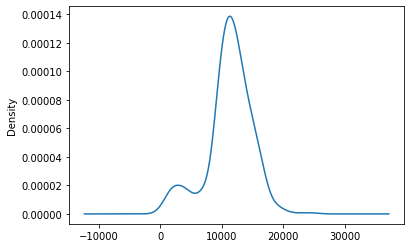

In [18]:
daily_sales_ts.plot(kind='kde')

#### 2.3.2 Products offered

How many products are offered by the store on week 50 ? In order to answer this question we have to : 
- Filter all transactions done on week 50,
- List all product IDs for those transactions,
- Count how many unique product IDs we have.

In [12]:
transactions.loc[transactions['WEEK_NO'] == 50]['PRODUCT_ID'].nunique()

11861

This gives us a total of **11861** products bought on week 50. 

#### 2.3.3 Best selling product overall

Let's consider, both best selling products in terms of units sold, and in terms of revenue generate.  
  
First, in order to find the best selling product, we need to group transactions by product IDs (`PRODUCT_ID`). And then, in order to get 
- the best selling in terms of units, sum `QUANTITY` for each product and get the top one,
- the one generating the most revenue, sum `SALES_VALUE` for each product and get the top one.

In [15]:
transactions_per_products = transactions.groupby('PRODUCT_ID');

# Per units sold
best_unit_selling_products = transactions_per_products['QUANTITY'].sum().sort_values(ascending=False)
best_unit_selling_product_id = best_unit_selling_products.index[0]
overall_amount_sold = best_unit_selling_products.values[0]
print('Best selling product is product ' + str(best_unit_selling_product_id) + ', sold ' + str(overall_amount_sold) + ' times overall.')

# Per revenue generated
best_selling_products = transactions_per_products['SALES_VALUE'].sum().sort_values(ascending=False)
best_selling_product_id = best_selling_products.index[0]
overall_revenue_generated = best_selling_products.values[0]
print('Best selling product is product ' + str(best_unit_selling_product_id) + ', generating $' + str(overall_revenue_generated) + ' overall.')

Best selling product is product 6534178, sold 204770364 times overall.
Best selling product is product 6534178, generating $477754.4900000089 overall.


Product **6534178** is both the most sold per units and the one generating the most revenue. We can get further information about the product by looking into the products dataframe :

In [16]:
products.loc[products['PRODUCT_ID'] == best_unit_selling_product_id]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


The best selling product is product number **6534178**, which is *Regular Gasoline*. It was sold **204770364** times overall and generated **\$477754.49** in total. The total quantity sold seems really large with regards for the total number of transactions. Let's have a deeper look by computing the median quantity sold by transactions:

In [17]:
transactions.loc[transactions["PRODUCT_ID"] == best_unit_selling_product_id]["QUANTITY"].median()

10535.5

With a median *10535 units* sold per gas transaction, we can think that gasoline is probably sold by thousandths of gallon, which explains the large quantity sold.

### 2.4 Predictive Models

#### 2.4.1 ARIMA

[ARIMA model](https://arxiv.org/pdf/1704.04110.pdf) has three hyper-parameters :
- `d`: This hyper-parameter is the order of differencing. It use when the timeserie is not stationary (statistical properties of the time series remain approximatively constant over time). When it is not, time observation are replaced by the difference between them and a lagged observation. This difference can be repeated a number of times until the serie is stationary. This is the order of differencing.
- `p`: Auto-regression term. Auto-regression expresses the dependent relationship between an data point and some number of lagged data points. The parameter is thus the number of lag observations included in the model.
- `q`: Moving average is the dependency between a data point and a residual error from a moving average model applied to lagged data points. The parameter is thus size of the moving average window.

We are going to determine each of them in the following parts, using the Box-Jenkins methodology [2]. Before doing so, we will remove the first 4 months of our time serie, as we saw a trend which suggests the business had an ongoing sales growth that stopped, and thus we don't want to convey that growth period in our model.

In [48]:
daily_sales_ts_copy = daily_sales_ts.copy() # We keep the original data
daily_sales_ts = daily_sales_ts[4*30:]

##### 2.4.1.1 Stationarity analysis and differencing hyper-parameter (d) estimation 

In order to estimate the differencing hyper-parameter, we need to know if the time serie is stationary or not. To do so, we are going to use three tools :
- Rolling statistics analysis,
- Time serie components decomposition (trend, seasonality),
- Augmented Dickey-Fuller test.

Here is the implementation of each of them:

In [31]:
def plot_rolling_statistics(timeserie):
    """
    Ploting rolling mean and std over the original time serie to see if the are dependent of the time.
    """
    rolling_mean = timeserie.rolling(5).mean()
    rolling_std = timeserie.rolling(5).std()
    timeserie = plt.plot(timeserie, color='black', label='timeserie')
    mean = plt.plot(rolling_mean, label='rolling mean', color='red')
    std = plt.plot(rolling_std, label='rolling std', color='purple')
    plt.legend(loc='best')

def plot_timeserie_decomposition(timeserie):
    """
    Ploting timeserie decomposition in order to see trends and seasonality.
    """
    decomposition = sm.tsa.seasonal_decompose(timeserie)
    return decomposition
    
def augmented_dickeyfuller_test(timeserie):
    """
    Runs an augmented Dickey-Fuller test in order to determine if the timeserie is stationary.
    """
    adfullertest = sm.tsa.stattools.adfuller(timeserie)
    return "Augmented Dickey-Fuller test results\nTest statistic: " + str(adfullertest[0]) + "\np-value: " + str(adfullertest[1]) + "\nLevels: " + str(adfullertest[4])

We can run a full analysis on our original time serie, and the time serie differenced once :

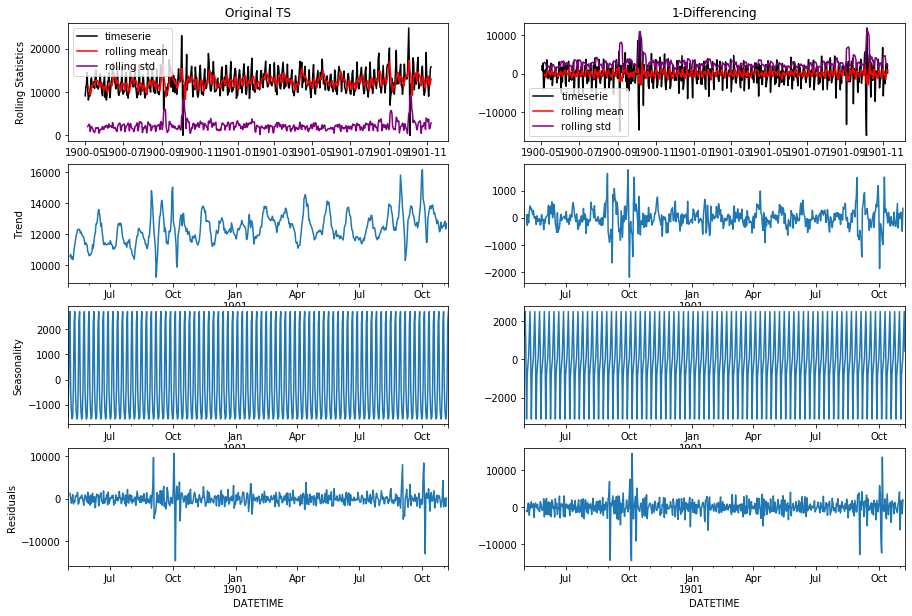

In [49]:
# Preparing subplot
figs, axes = plt.subplots(4, 2, figsize=(15,10))
axes[0][0].set_title("Original TS")
axes[0][1].set_title("1-Differencing")
axes[0][0].set_ylabel("Rolling Statistics")
axes[1][0].set_ylabel("Trend")
axes[2][0].set_ylabel("Seasonality")
axes[3][0].set_ylabel("Residuals")

# Rolling statistics
plt.sca(axes[0, 0])
plot_rolling_statistics(daily_sales_ts)
plt.sca(axes[0, 1])
plot_rolling_statistics(daily_sales_ts.diff().dropna())

# Seasonality
decomposition_ots = plot_timeserie_decomposition(daily_sales_ts)
decomposition_ots.trend.plot(ax=axes[1, 0], legend=False)
decomposition_ots.seasonal.plot(ax=axes[2, 0], legend=False)
decomposition_ots.resid.plot(ax=axes[3, 0], legend=False)
decomposition_1dfts = plot_timeserie_decomposition(daily_sales_ts.diff().dropna())
decomposition_1dfts.trend.plot(ax=axes[1, 1], legend=False)
decomposition_1dfts.seasonal.plot(ax=axes[2, 1], legend=False)
decomposition_1dfts.resid.plot(ax=axes[3, 1], legend=False)

In [50]:
# Dickey-Fuller tests
print("Original TS : ")
print(augmented_dickeyfuller_test(daily_sales_ts))
print("\n1-Differencing : ")
print(augmented_dickeyfuller_test(daily_sales_ts.diff().fillna(0)))

Original TS : 
Augmented Dickey-Fuller test results
Test statistic: -5.287129047532115
p-value: 5.822004192978842e-06
Levels: {'1%': -3.442450336733213, '5%': -2.8668774460774498, '10%': -2.5696126760816553}

1-Differencing : 
Augmented Dickey-Fuller test results
Test statistic: -10.215812553384577
p-value: 5.485622693758745e-18
Levels: {'1%': -3.4425861905056556, '5%': -2.8669372502674824, '10%': -2.5696445454608505}


From this graphical analysis, there are some key takeaways:
- Mean and standard deviation are not dependent on the time in both cases, which suggests stationarity.
- There is at least on seasonality, which is weekly. As a consequence, we will have to use a Seasonal ARIMA model (SARIMA). - There might be a second seasonality, yearly this time, that we can guees thanks to two spikes (appearing in october in our graphs). However, we only have one cycle between the two spikes, so we can't determine if it is a cyclic phenomenon or a seasonal phenomenon. Our model may fail to represent it. 

Complementary Augmented Dicker-Fuller tests confirm that our time serie is stationary without differenciation, as the H0 hypotesis is rejected ($p-value < 0.05$ and the test statistic is lower than $-3.44$, the critical values for Dickey–Fuller t-distribution for our serie size). **Thus $d = 0$**

##### 2.4.1.2 Auto-regression hyper-parameter (p)

In order to estimate the `p` hyper-parameter, we are going to have a look to the Partial Autocorrelation Function (PACF). It measures the correlation between the time serie with a lagged version of itself but also eliminate variations already explained by the intervening comparisons. 

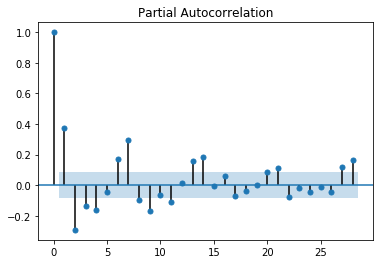

In [51]:
pacf = smg.tsaplots.plot_pacf(daily_sales_ts) # We store the figure to avoid double display in jupyter

**There are a few significant spikes (for lags of 1, 2, 3, 4, 6, 7), so we can only reduce our search space, by saying that $p \in \{1,2,3,4,6,7\}$.**

##### 2.4.1.3 Moving Average hyper-parameter (q)

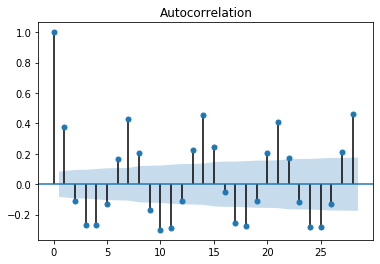

In [40]:
acf = smg.tsaplots.plot_acf(daily_sales_ts)

Again, there is not enough evidence that an autocorrelation is significantly larger than the others. We will do a grid search to confirm which value fits the best for `q`. However, a there's a significant autocorrelation for a lag of 1,3,4 and 7. So we also reduce our search space to **$q \in \{1,3,4,7\}$**.
Moreover, spikes appears every 7 lags, which confirms a seasonality of 7 (**$s = 7$**).

##### 2.4.1.4 Model fitting and evaluation

In order to complete our hyper-parameters tuning, we are going to do a grid search among the search space we previously defined (we also add $(P, D, Q, s)$ seasonal hyper-parameters [3]) :
- $p \in \{1,2,3,4,6,7\}$
- $d = 0$
- $q \in \{1,3,4,7\}$
- $P \in \left[0,2\right]$
- $D \in \left[0,2\right]$
- $Q \in \left[0,2\right]$
- $s = 7$

This gives us 648 models to fit and evaluate. The evaluation function will be the root mean squared.

In [62]:
##################################################################################
#                                    GRID SEARCH                                 #
##################################################################################

def sarima_forecast(train, order, seasonal_order):
    """
    Trains a SARIMA model with the given order and seasonal order, on a train set, fits its parameters.
    """
    model = sm.tsa.statespace.SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    return model_fit

def model_rmse(original, prediction):
    """
    Compute the root mean squared error of predictions over an original set. 
    """
    return math.sqrt(sklearn.metrics.mean_squared_error(original, prediction))

def plot_prediction(timeserie, predictions):
    """
    Plotting predictions over the original time serie.
    """
    plt.plot(timeserie, 'r') # plotting t, a separately 
    plt.plot(predictions, 'b') # plotting t, b separately 
    plt.show()
    
# Splitting train and test set (66%/33%)
split = int(0.66*len(daily_sales_ts))
train, test = daily_sales_ts[:split], daily_sales_ts[split:]
    
# Generating hyper-parameters set
p = [1, 2, 3, 4, 6, 7]
d = [0]
q = [1, 3, 4, 7]
P = [0, 1, 2]
D = [0, 1, 2]
Q = [0, 1, 2]
s = [7]
orders = itertools.product(p, d, q)
seasonal_orders = itertools.product(P, D, Q, s)
hyperparameters_grid = itertools.product(orders, seasonal_orders)
models_eval = pd.Series()

for hyperparameters in hyperparameters_grid:
    try:
        model = sarima_forecast(train, order=hyperparameters[0], seasonal_order=hyperparameters[1])
        predictions = model.predict(len(train), len(train) + len(test) - 1)
        rmse = model_rmse(test, predictions)
        models_eval[str(hyperparameters)] = rmse
    except:
        continue
    
print(models_eval.idxmin())
print(models_eval.min())

((3, 0, 3), (0, 1, 1, 7))
2064.0267570690585


c:\users\launeau\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Grid search gives us a minimum root mean squared of (**$2064.02$**) for the model **$SARIMA((3, 0, 3)(0, 1, 1)[7])$**. We can plot it to get a visual interpetation of it :

c:\users\launeau\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\launeau\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\launeau\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


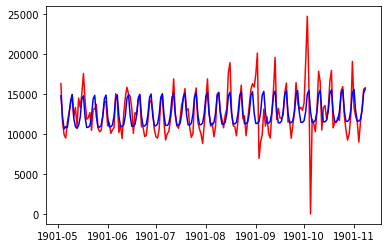

In [59]:
sarima_model = sarima_forecast(train, (3, 0, 3), (0, 1, 1, 7))
plot_prediction(test, sarima_model.predict(len(train), len(train) + len(test) - 1))

The model is clearly able to capture three of the time serie's caracteristics :
- The weekly seasonality,
- The mean sales value over a long period of time,
- The slight increase in sales over time.

However, it fails to capture :
- The important spike appearing around 1901-10, that is linked to the probable yearly seasonality,
- The important weekly fluctuations in mean sales values.

The relative poorness of the model could be limited by, first, having at least one more year of data, to captre weekly fluctuations and yearly seasonality, or secondly, by adding fourier terms to represent the multiple seasonality (weekly + yearly) into our model.

However, we can still give an **approximation of the sales value for week 98** :

In [61]:
sarima_model.predict(97*7 + 1, 98*7).sum()

95684.7173013327

**Our model gives a $\$95,684.71$ total sales predictions for week 98.**

#### 2.4.2 Random Forests

## 3. Discussion and feedback

## 4. Resources

[1] Box, G. E. P., and G. C. Tiao. “Intervention Analysis with Applications to Economic and Environmental Problems.” Journal of the American Statistical Association, vol. 70, no. 349, 1975, pp. 70–79.  
[2] Din, Marilena. (2015). ARIMA by Box Jenkins Methodology for Estimation and Forecasting Models in Higher Education. 10.13140/RG.2.1.1259.6888.  
[3] Kumar, S.V. & Vanajakshi, L. Eur. Transp. Res. Rev. (2015) 7: 21. https://doi.org/10.1007/s12544-015-0170-8